# Batched SGD

### **Noise Model Assumption**

Assume the stochastic gradient noise for each sample is independently and identically distributed (i.i.d.) as a normal random variable. Specifically, for the $i$-th sample, the gradient noise satisfies:
$$
\varepsilon_i \sim \mathcal{N}(0, \sigma^2),
$$
where $\sigma^2$ is the variance of the single-sample gradient noise, and the noise has zero mean, ensuring an unbiased estimate.


### **Statistical Properties of Batch Gradient Noise**

Let the batch size be $B$. The average gradient noise over the batch is:
$$
\bar{\varepsilon} = \frac{1}{B} \sum_{i=1}^B \varepsilon_i.
$$

By the properties of normal distributions, the sum of independent normal variables is also normally distributed. Thus:

$$
\bar{\varepsilon} \sim \mathcal{N}\left(0, \frac{\sigma^2}{B}\right).
$$

**Proof:**

- **Expectation (Mean):**
  $$
  \mathbb{E}[\bar{\varepsilon}] = \frac{1}{B} \sum_{i=1}^B \mathbb{E}[\varepsilon_i] = 0.
  $$
- **Variance:**
  $$
  \text{Var}(\bar{\varepsilon}) = \text{Var}\left(\frac{1}{B} \sum_{i=1}^B \varepsilon_i\right) = \frac{1}{B^2} \sum_{i=1}^B \text{Var}(\varepsilon_i) = \frac{1}{B^2} \cdot B\sigma^2 = \frac{\sigma^2}{B}.
  $$


### **Stability Analysis of Parameter Updates**

The parameter update rule in SGD is:
$$
\theta_{t+1} = \theta_t - \eta \left( \nabla L(\theta_t) + \bar{\varepsilon} \right),
$$
where $\eta$ is the learning rate, $\nabla L(\theta_t)$ is the true gradient, and $\bar{\varepsilon}$ is the batch gradient noise. The fluctuation in parameter updates is primarily caused by the noise term $\eta \bar{\varepsilon}$.

- **Variance of the Noise Term:**
  $$
  \text{Var}(\eta \bar{\varepsilon}) = \eta^2 \cdot \text{Var}(\bar{\varepsilon}) = \eta^2 \cdot \frac{\sigma^2}{B}.
  $$
  Clearly, as the batch size $B$ increases, the variance $\text{Var}(\eta \bar{\varepsilon})$ decays at a rate of $1/B$.


### **Stability Conclusion**

- **Small Batch ($B=1$):**  
  The noise variance is $\eta^2 \sigma^2$, and the parameter updates are dominated by the noise of a single sample, leading to significant fluctuations and poor stability.

- **Large Batch ($B \gg 1$):**  
  The noise variance reduces to $\eta^2 \sigma^2 / B$. The noise is averaged across multiple samples, and the parameter updates align more closely with the true gradient direction, resulting in smoother trajectories and significantly improved stability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


np.random.seed(213)
w_true = 3.142    # 真实权重
b_true = -1.423    # 真实偏置
noise = 5.0  # 数据噪声
num_samples = 1000  # 数据量
initial_params = [-4.0, 0.0]  # 初始参数
learning_rate = 0.1  # 学习率
num_steps = 100  # 迭代次数
batch_sizes = [1, 10, 100]  # 三个batch大小

In [2]:
x = np.random.uniform(0, 2, num_samples)
noise = np.random.normal(0, noise, num_samples)
y = w_true * x + b_true + noise

In [3]:
def compute_gradient(x_batch, y_batch, w, b):
    y_pred = w * x_batch + b
    error = y_pred - y_batch
    grad_w = 2 * np.mean(error * x_batch)
    grad_b = 2 * np.mean(error)
    return grad_w, grad_b

def sgd_linear(data_x, data_y, initial_params, batch_size, lr, num_steps):
    params = np.array(initial_params, dtype=np.float64)
    history = np.zeros((num_steps + 1, 2))
    history[0] = params
    for t in range(num_steps):
        indices = np.random.choice(len(data_x), batch_size)
        x_batch = data_x[indices]
        y_batch = data_y[indices]
        grad_w, grad_b = compute_gradient(x_batch, y_batch, *params)
        params -= lr * np.array([grad_w, grad_b])
        history[t + 1] = params
    return history

In [4]:
paths = []
for bs in batch_sizes:
    path = sgd_linear(x, y, initial_params, bs, learning_rate, num_steps)
    paths.append(path)

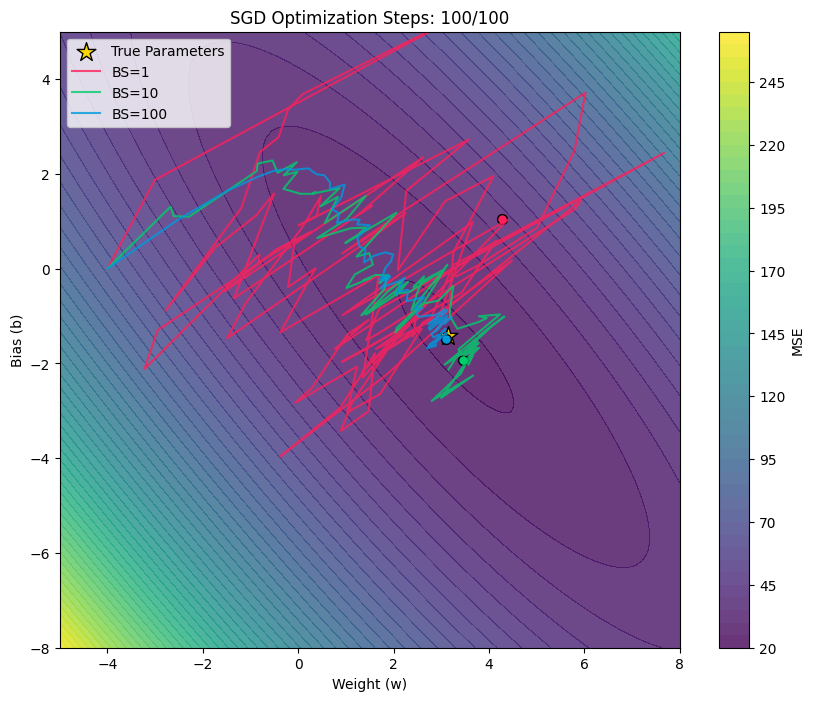

In [5]:
w_grid = np.linspace(-5, 8, 100)
b_grid = np.linspace(-8, 5, 100)
W, B = np.meshgrid(w_grid, b_grid)
Z = np.zeros_like(W)
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        Z[i,j] = np.mean((W[i,j]*x + B[i,j] - y)**2)

fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(W, B, Z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(contour, label='MSE')
ax.scatter(w_true, b_true, c='gold', s=200, marker='*', edgecolor='black', 
           label='True Parameters')

colors = ['#FF1F5B', '#00CD6C', '#009ADE']
lines = [ax.plot([], [], color=c, lw=1.5, alpha=0.8, 
         label=f'BS={bs}')[0] for c, bs in zip(colors, batch_sizes)]
dots = [ax.scatter([], [], color=c, s=50, edgecolor='black') for c in colors]

def update(frame):
    ax.set_title(f'SGD Optimization Steps: {frame}/{num_steps}')
    for line, dot, path in zip(lines, dots, paths):
        line.set_data(path[:frame, 0], path[:frame, 1])
        dot.set_offsets(path[frame] if frame < len(path) else path[-1])
    return lines + dots

anim = FuncAnimation(fig, update, frames=num_steps+1, interval=100, blit=True)
ax.legend()
ax.set_xlabel('Weight (w)')
ax.set_ylabel('Bias (b)')
ax.set_xlim(w_grid.min(), w_grid.max())
ax.set_ylim(b_grid.min(), b_grid.max())

HTML(anim.to_html5_video())

# anim.save('./assets/batched_sgd.gif', writer='pillow', fps=15)